In [1]:
import os

import numpy as np
import scipy

import mne
import yasa
import matplotlib.pyplot as plt

plt.rcParams.update({'axes.unicode_minus': False})

mne.set_log_level('Critical')

In [38]:
animal = '0629'
sessions = os.listdir(rf'data/{animal}')
session = sessions[0]

In [46]:
raw = mne.io.read_raw_edf(rf'data/{animal}/{session}/raw_annotated.edf', preload=True)
raw.pick(['F3', 'FZ', 'F4', 'C3', 'CZ', 'C4', 'P3', 'PZ', 'P4'])
raw.set_montage('standard_1020', match_case=False)
raw.notch_filter(list(range(50, 500, 50)))

Measurement date,"January 24, 2024 11:19:22 GMT"
Experimenter,Unknown
Participant,X
Digitized points,12 points
Good channels,9 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,500.00 Hz


In [47]:
%matplotlib notebook
raw.plot_sensors(show_names=True)
plt.show()

<IPython.core.display.Javascript object>

In [48]:
%matplotlib notebook
spectrum = raw.compute_psd(fmax=100)
spectrum.plot()
plt.show()

<IPython.core.display.Javascript object>

Fp2, O2, M2, T6

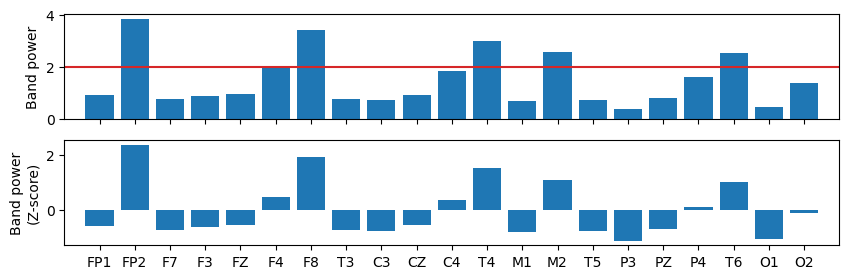

In [38]:
%matplotlib inline
bandpowers_high = yasa.bandpower(raw, bands=[(70, 80, 'high')], relative=False)

fig, ax = plt.subplots(2, 1, figsize=(10, 3), sharex='all')
plt.axes(ax[0])
plt.bar(list(bandpowers_high.index), bandpowers_high['high'])
plt.hlines(2, xmin=-10, xmax=100, colors='tab:red')
plt.ylabel('Band power')

plt.axes(ax[1])
plt.bar(list(bandpowers_high.index), scipy.stats.zscore(bandpowers_high['high']))
plt.ylabel('Band power\n(Z-score)')

plt.xlim(-1, len(bandpowers_high.index))
plt.show()

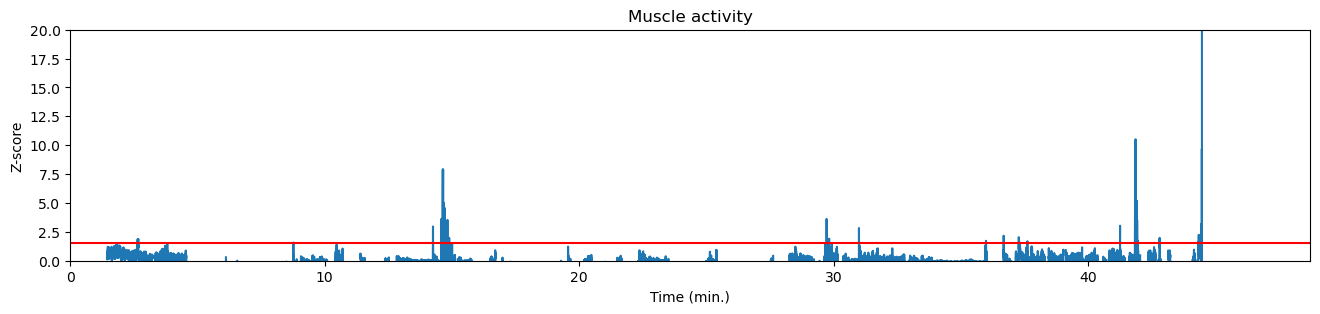

In [50]:
%matplotlib inline
# Muscle activity
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    raw,
    ch_type="eeg",
    threshold=1.5,
    min_length_good=2,
    filter_freq=[110, 160],
)

_, ax = plt.subplots(figsize=(16, 3))
ax.plot(raw.times / 60, scores_muscle)
ax.axhline(y=1.5, color="r")
ax.set(xlabel="Time (min.)", ylabel="Z-score", title="Muscle activity", xlim=(0, raw.times[-1] / 60), ylim=(0, 20))
plt.show()

In [51]:
raw.filter(1, 30)
raw.set_annotations(raw.annotations + annot_muscle)
raw.plot()

In [52]:
raw.copy().set_eeg_reference('average').plot()

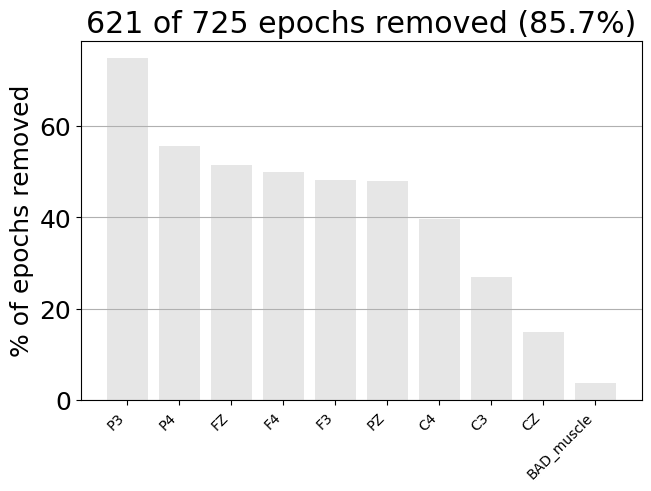

In [143]:
epochs = mne.make_fixed_length_epochs(raw.copy().set_eeg_reference('average'), duration=2, preload=True)
epochs = epochs.drop_bad(flat=dict(eeg=5e-6), reject={'eeg': 30e-6})
epochs.plot_drop_log(ignore=['Bad band'])
plt.show()

In [144]:
ica = mne.preprocessing.ICA(n_components=None)
ica.fit(epochs)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,24 iterations on epochs (208000 samples)
ICA components,8
Available PCA components,9
Channel types,eeg
ICA components marked for exclusion,—


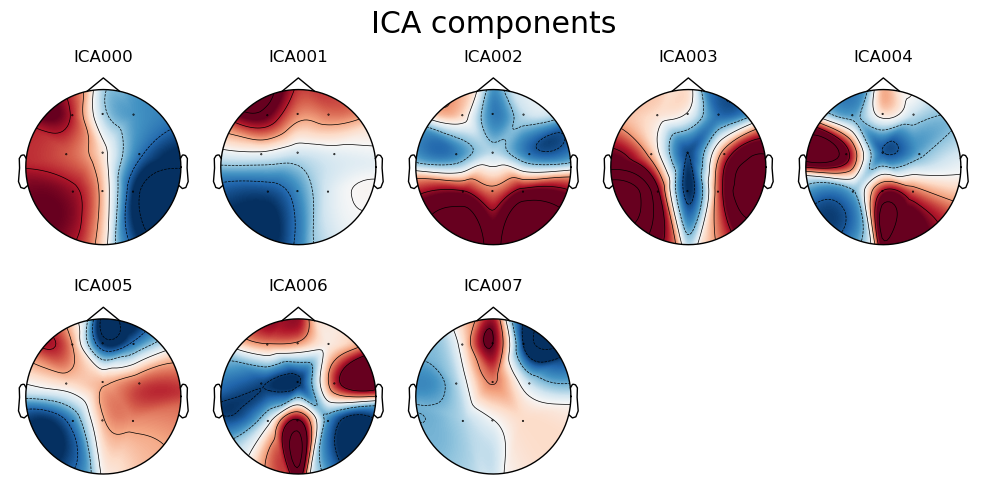

In [145]:
ica.plot_components()
plt.show()

In [146]:
ica.plot_sources(epochs)

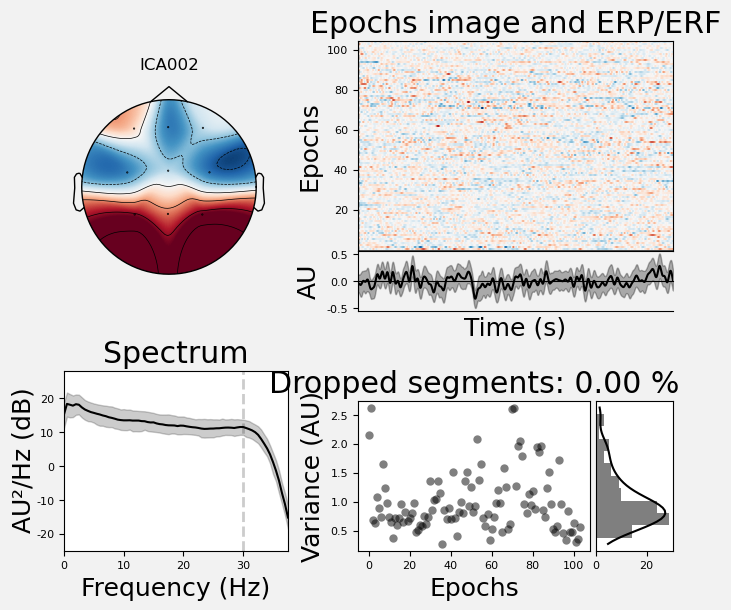

[<Figure size 700x600 with 6 Axes>]

In [150]:
ica.plot_properties(epochs, picks=2)

In [130]:
ica.exclude = [0, 1]
ica.apply(epochs)
epochs.plot()

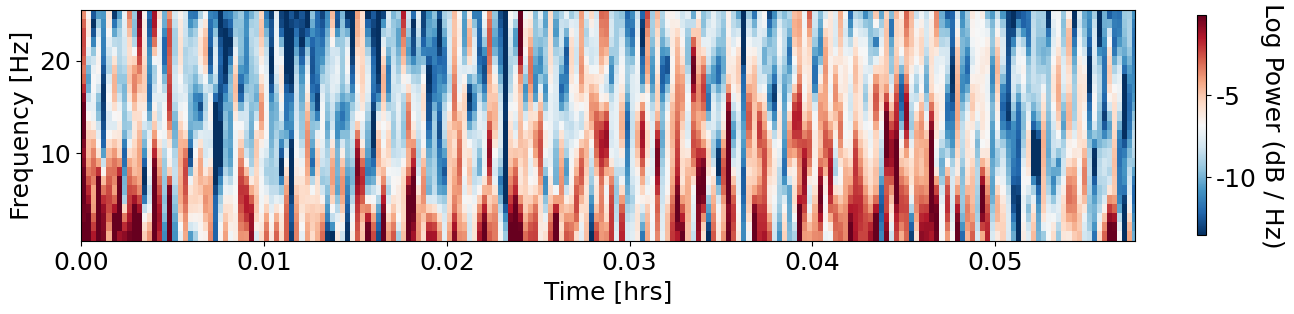

In [154]:
# data = 
# _,ax = plt.subplots(figsize=(16, 3))
yasa.plot_spectrogram(epochs.copy().pick('CZ').get_data(units='uV').reshape(-1), sf=epochs.info['sfreq'], win_sec=1)
plt.gcf().set_size_inches((16, 3))
plt.show()